# Práctica: Tensores y sus Aplicaciones
En esta práctica, trabajaremos con tensores desde su matricización hasta su aplicación práctica para la compresión de datos.

### Objetivos
1. Entender cómo vectorizar y matriciar un tensor.
2. Construir tensores a partir de tensores de rango 1 usando el producto externo.
3. Implementar el modelo PARAFAC para descomposición tensorial.
4. Aplicar tensores para la compresión de un vídeo.

In [24]:
print(128*64 + 64 + 128*64 + 128)

16576


## 3.1. Implementación del Modelo PARAFAC con CVX
El modelo PARAFAC descompone un tensor en una suma de productos externos de vectores. Esto equivale a descomponer el tensor en matrices \(A\), \(B\), y \(C\).

Iter   0 | Reconstruction error: 1.879918e+00
Iter   1 | Reconstruction error: 1.961308e+00
Iter   2 | Reconstruction error: 1.963954e+00
Iter   3 | Reconstruction error: 1.798940e+00
Iter   4 | Reconstruction error: 1.836147e+00
Iter   5 | Reconstruction error: 1.956055e+00
Iter   6 | Reconstruction error: 1.904947e+00
Iter   7 | Reconstruction error: 1.817109e+00
Iter   8 | Reconstruction error: 1.873106e+00
Iter   9 | Reconstruction error: 1.851325e+00
Iter  10 | Reconstruction error: 1.967814e+00
Iter  11 | Reconstruction error: 1.902877e+00
Iter  12 | Reconstruction error: 1.942672e+00
Iter  13 | Reconstruction error: 1.930229e+00
Iter  14 | Reconstruction error: 1.942693e+00
Iter  15 | Reconstruction error: 1.904720e+00
Iter  16 | Reconstruction error: 1.900551e+00
Iter  17 | Reconstruction error: 1.922620e+00
Iter  18 | Reconstruction error: 1.913035e+00
Iter  19 | Reconstruction error: 1.931548e+00
Iter  20 | Reconstruction error: 1.926431e+00
Iter  21 | Reconstruction error: 1

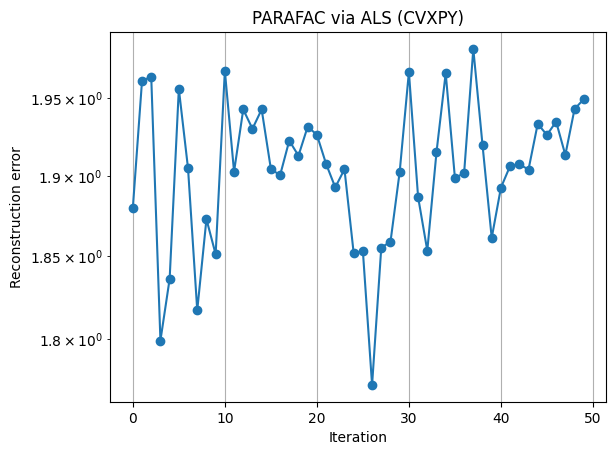

In [1]:
import numpy as np
import cvxpy as cp
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt

# --------------------------------------------------
# Tensor dimensions
# --------------------------------------------------
I, J, K, F = 3, 4, 5, 2
np.random.seed(0)

# Tensor
X = np.random.rand(I, J, K)

# --------------------------------------------------
# Mode-n unfoldings
# --------------------------------------------------
X1 = X.transpose().reshape(I, -1)      # (I, KJ)
X2 = X.transpose().reshape(J, -1)      # (J, KI)
X3 = X.transpose().reshape(K, -1)      # (K, JI)

# --------------------------------------------------
# Initialization (ONCE)
# --------------------------------------------------
A_val = np.random.rand(I, F)
B_val = np.random.rand(J, F)
C_val = np.random.rand(K, F)

# --------------------------------------------------
# CVXPY variables
# --------------------------------------------------
A = cp.Variable((I, F))
B = cp.Variable((J, F))
C = cp.Variable((K, F))

# --------------------------------------------------
# ALS loop
# --------------------------------------------------
max_iter = 50
errors = []

for it in range(max_iter):

    # ===== Update A =====
    Z = khatri_rao(C_val, B_val)   # (JK, F)
    problem_A = cp.Problem(cp.Minimize(cp.norm(X1 - A @ Z.T, 'fro')**2))
    A.value = A_val
    problem_A.solve(solver=cp.ECOS)
    A_val = A.value

    # ===== Update B =====
    # Para actualizar B, usamos C y A
    Z = khatri_rao(C_val, A_val) 
    problem_B = cp.Problem(cp.Minimize(cp.norm(X2 - B @ Z.T, 'fro')**2))
    B.value = B_val
    problem_B.solve(solver=cp.ECOS)
    B_val = B.value

    # ===== Update C =====
    # Para actualizar C, usamos B y A
    Z = khatri_rao(B_val, A_val)
    problem_C = cp.Problem(cp.Minimize(cp.norm(X3 - C @ Z.T, 'fro')**2))
    C.value = C_val
    problem_C.solve(solver=cp.ECOS)
    C_val = C.value

    # ===== Normalize (important) =====
    for f in range(F):
        n = np.linalg.norm(A_val[:, f])
        if n > 0:
            A_val[:, f] /= n
            B_val[:, f] *= n

    # ===== Reconstruction error =====
    X_hat = np.einsum('if,jf,kf->ijk', A_val, B_val, C_val)
    err = np.linalg.norm(X - X_hat)
    errors.append(err)

    print(f"Iter {it:3d} | Reconstruction error: {err:.6e}")

# --------------------------------------------------
# Final results
# --------------------------------------------------
print("\nFinal factor matrices:")
print("A:\n", A_val)
print("B:\n", B_val)
print("C:\n", C_val)

# --------------------------------------------------
# Error plot
# --------------------------------------------------
plt.figure()
plt.plot(errors, marker='o')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error")
plt.title("PARAFAC via ALS (CVXPY)")
plt.grid(True)
plt.show()

## 3.2. Implementación del Modelo PARAFAC mediante Alternating Least Squares (ALS)

Iter   0 | Reconstruction error: 8.640179e-01
Iter   1 | Reconstruction error: 8.630812e-01
Iter   2 | Reconstruction error: 7.771472e-01
Iter   3 | Reconstruction error: 8.277361e-01
Iter   4 | Reconstruction error: 7.506238e-01
Iter  10 | Reconstruction error: 8.564408e-01
Iter  20 | Reconstruction error: 7.799688e-01
Iter  30 | Reconstruction error: 8.665488e-01
Iter  40 | Reconstruction error: 9.630842e-01
Iter  50 | Reconstruction error: 7.918316e-01
Iter  60 | Reconstruction error: 8.109335e-01
Iter  70 | Reconstruction error: 8.414541e-01
Iter  80 | Reconstruction error: 8.152825e-01
Iter  90 | Reconstruction error: 8.505002e-01
Iter 100 | Reconstruction error: 8.186989e-01
Iter 110 | Reconstruction error: 7.876243e-01
Iter 120 | Reconstruction error: 7.906098e-01
Iter 130 | Reconstruction error: 8.327853e-01
Iter 140 | Reconstruction error: 8.024902e-01
Iter 150 | Reconstruction error: 7.940599e-01
Iter 160 | Reconstruction error: 8.530309e-01
Iter 170 | Reconstruction error: 9

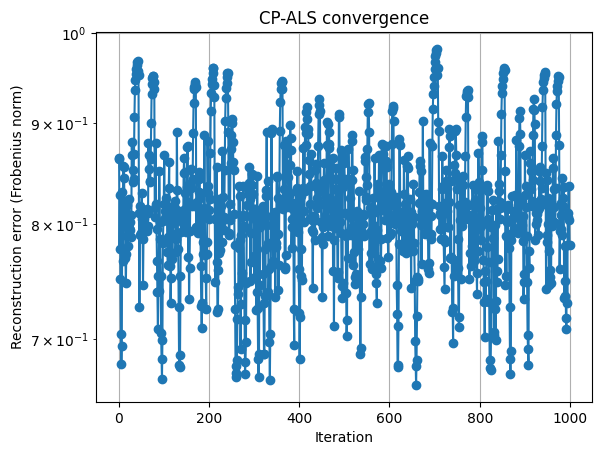

[0.8640179230317665, 0.8630811838778316, 0.7771471939645587, 0.8277360654304987, 0.7506237828507664, 0.7041573876112001, 0.679642980685827, 0.6936052081423998, 0.8307052990776328, 0.7659037063143032, 0.856440758090134, 0.8548315297444491, 0.8442586936828808, 0.8217788946300963, 0.8000980361839906, 0.7691746082344418, 0.7472485586406984, 0.7729011440814922, 0.8178439331230801, 0.7889477419141628, 0.7799688274294544, 0.795865053469885, 0.7962735200751434, 0.8237455289299921, 0.7960948590515228, 0.7942371252082845, 0.8017085846284873, 0.8086432008332021, 0.7882914921986727, 0.8802118555760167, 0.866548799974854, 0.8522160773588837, 0.8405508636499938, 0.8430242293189235, 0.8676588051843369, 0.9060138745960984, 0.934806420568849, 0.946536934550552, 0.9533523824279985, 0.9581275836913382, 0.9630842392928494, 0.9665292309628809, 0.9670235750362333, 0.9556705882716119, 0.9515832804964622, 0.8100326438343849, 0.7266652534918068, 0.7894328699185126, 0.8165877915053761, 0.8118662091315703, 0.791

In [22]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import khatri_rao

# -----------------------------
# Problem dimensions
# -----------------------------
I, J, K, F = 3, 4, 5, 2
np.random.seed(0)

# Tensor
X = np.random.rand(I, J, K)

# Mode-n unfoldings
X1 = X.transpose().reshape(I, -1)      # (I, KJ)
X2 = X.transpose().reshape(J, -1)      # (J, KI)
X3 = X.transpose().reshape(K, -1)      # (K, JI)

# -----------------------------
# Initialization
# -----------------------------
# En lugar de X = np.random.rand(I, J, K)
# Crea un tensor que sea EXACTAMENTE la suma de 2 componentes (Rango 2)
A_true = np.random.rand(I, F)
B_true = np.random.rand(J, F)
C_true = np.random.rand(K, F)

# -----------------------------
# CP-ALS
# -----------------------------
max_iter = 1000
tol = 1e-6
prev_error = np.inf
errors = []

for it in range(max_iter):
    try:
        # ---- Update A ----
        Z = khatri_rao(C, B)
        # Usamos una pequeña regularización (rcond) para ayudar a la convergencia
        A = np.linalg.lstsq(Z, X1.T, rcond=1e-10)[0].T
        # Normalizar A
        A /= np.linalg.norm(A, axis=0)

        # ---- Update B ----
        Z = khatri_rao(C, A)
        B = np.linalg.lstsq(Z, X2.T, rcond=1e-10)[0].T
        # Normalizar B
        B /= np.linalg.norm(B, axis=0)

        # ---- Update C ----
        Z = khatri_rao(B, A)
        C = np.linalg.lstsq(Z, X3.T, rcond=1e-10)[0].T
        # Normalizar C
        C /= np.linalg.norm(C, axis=0)

    except np.linalg.LinAlgError:
        print(f"¡Error de convergencia SVD en iteración {it}! Reiniciando factores...")
        A = np.random.rand(I, F)
        B = np.random.rand(J, F)
        C = np.random.rand(K, F)
        continue

    # ---- Reconstruction error ----
    X_hat = np.einsum('if,jf,kf->ijk', A, B, C)
    error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
    errors.append(error)

    if (it % 10 == 0) or (it < 5): # Reducimos prints para no saturar
        print(f"Iter {it:3d} | Reconstruction error: {error:.6e}")

    # Condición de parada por convergencia (cambio pequeño en el error)
    if abs(prev_error - error) < tol:
        print(f"Converged at iter {it} with error {error:.6e}")
        print('It is over')
        break

    prev_error = error

# -----------------------------
# Plot error evolution
# -----------------------------
plt.figure()
plt.plot(errors, marker='o')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error (Frobenius norm)")
plt.title("CP-ALS convergence")
plt.grid(True)
plt.show()

print(errors)






## 3.3. Implementación del Modelo PARAFAC mediante tensorly

In [ ]:
pip install tensorly

In [33]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
import matplotlib.pyplot as plt

# Configuración inicial según la imagen
np.random.seed(3)
X = tl.tensor(np.random.rand(5, 4, 7))


def reconstruction_error(tensor, factors):
    reconstructed_tensor = tl.cp_to_tensor(factors)
    return np.mean((tensor - reconstructed_tensor).flatten()**2)

for i in range(1, 31):
    factors = parafac(X, rank=i)
    error = reconstruction_error(X, factors)

    if error < 1e-5:
        print("Rango mínimo encontrado", i)
        break

Rango mínimo encontrado 12


In [13]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac

# Use NumPy backend
tl.set_backend('numpy')

# Tensor dimensions
I, J, K = 3, 4, 5
rank = 5

# Random tensor
X = np.random.rand(I, J, K)

# CP / PARAFAC decomposition
weights, factors = parafac(
    X,
    rank=rank,
    n_iter_max=100,
    tol=1e-6,
    init='random',
    normalize_factors=False,
    verbose=1
)

# Factors
A, B, C = factors

print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

from tensorly.cp_tensor import cp_to_tensor

X_hat = cp_to_tensor((weights, factors))

error = tl.norm(X - X_hat) / tl.norm(X)
print("Relative reconstruction error:", error)

print("\nFinal factor matrices:")
print("A:\n", A)
print("B:\n", B)
print("C:\n", C)

reconstruction error=0.3022237921449272
iteration 1, reconstruction error: 0.2445436456087236, decrease = 0.05768014653620357, unnormalized = 1.1282918727396682
iteration 2, reconstruction error: 0.2314639182446951, decrease = 0.013079727364028515, unnormalized = 1.0679437494189878
iteration 3, reconstruction error: 0.21997284472517847, decrease = 0.011491073519516615, unnormalized = 1.014925463751204
iteration 4, reconstruction error: 0.21085398955376958, decrease = 0.009118855171408896, unnormalized = 0.9728522781937555
iteration 5, reconstruction error: 0.20493118889167733, decrease = 0.005922800662092248, unnormalized = 0.9455252632788465
iteration 6, reconstruction error: 0.20034616397350666, decrease = 0.0045850249181706715, unnormalized = 0.924370567810872
iteration 7, reconstruction error: 0.19579051777416123, decrease = 0.004555646199345426, unnormalized = 0.9033514218461345
iteration 8, reconstruction error: 0.19085707461773455, decrease = 0.004933443156426687, unnormalized =

## 3.4. Tucker usando HOSVD

In [12]:
import numpy as np
from numpy.linalg import svd

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
R1, R2, R3 = 3, 3, 2
np.random.seed(0)

X = np.random.rand(I, J, K)

# Mode-n unfoldings
X1 = X.transpose(0, 2, 1).reshape(I, -1)      # (I, KJ)
X2 = X.transpose(1, 2, 0).reshape(J, -1)      # (J, KI)
X3 = X.transpose(2, 1, 0).reshape(K, -1)      # (K, JI)

# SVDs
U1, _, _ = svd(X1, full_matrices=False)
U2, _, _ = svd(X2, full_matrices=False)
U3, _, _ = svd(X3, full_matrices=False)

A = U1[:, :R1]
B = U2[:, :R2]
C = U3[:, :R3]

# Core tensor
G = np.einsum('ia,jb,kc,ijk->abc', A, B, C, X)

# Reconstruction
X_hat = np.einsum('ia,jb,kc,abc->ijk', A, B, C, G)

error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
print("Reconstruction error (HOSVD):", error)

print("\nFinal factor matrices:")
print("A:\n", A)
print("B:\n", B)
print("C:\n", C)

Reconstruction error (HOSVD): 0.35256378696432805

Final factor matrices:
A:
 [[-0.47321099  0.08983229 -0.67728888]
 [-0.4612937   0.54532971 -0.15140859]
 [-0.32091163 -0.3172683   0.066353  ]
 [-0.32584788 -0.76438631 -0.13234319]
 [-0.33249591  0.03513751  0.49414549]
 [-0.49352288  0.0914626   0.50225293]]
B:
 [[-0.46312524  0.0707673   0.25527667]
 [-0.41333455  0.11315165 -0.0295093 ]
 [-0.49003567 -0.5551393   0.50417921]
 [-0.40472893 -0.36081192 -0.82334326]
 [-0.45905239  0.73744411 -0.04326917]]
C:
 [[-0.51700829  0.47233787]
 [-0.48546934 -0.4875633 ]
 [-0.51831366  0.48985879]
 [-0.47788377 -0.54700761]]


## 3.5 Tucker usando tensorly

In [11]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor

tl.set_backend('numpy')

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
ranks = (4, 4, 4)
np.random.seed(0)

X = np.random.rand(I, J, K)

# Tucker decomposition
core, factors = tucker(
    X,
    rank=ranks,
    init='svd',
    n_iter_max=100,
    tol=1e-6
)

A, B, C = factors

# Reconstruction
X_hat = tucker_to_tensor((core, factors))

error =  tl.norm(X - X_hat) / tl.norm(X)
print("Reconstruction error (TensorLy Tucker):", error)

print("\nFinal factor matrices:")
print("A:\n", A)
print("B:\n", B)
print("C:\n", C)

Reconstruction error (TensorLy Tucker): 0.20032628074348202

Final factor matrices:
A:
 [[ 0.47291053 -0.03911681  0.70070985  0.22655964]
 [ 0.45838614 -0.55792014  0.15197108 -0.1241842 ]
 [ 0.32112529  0.30145336 -0.13594508 -0.46619213]
 [ 0.32646204  0.76027385  0.11102331  0.05511742]
 [ 0.33261927 -0.01181183 -0.48622945  0.76799537]
 [ 0.49588636 -0.13477764 -0.4676368  -0.3507978 ]]
B:
 [[ 0.46323643  0.03646568 -0.21094436  0.76121394]
 [ 0.40915914  0.11477707 -0.08704382 -0.62154127]
 [ 0.49226729 -0.61770633 -0.41872499 -0.16753822]
 [ 0.40376884 -0.24668927  0.87835599  0.03878714]
 [ 0.46113387  0.73693947 -0.03295415 -0.06831029]]
C:
 [[ 0.51619771 -0.48845271 -0.56127152 -0.42417939]
 [ 0.48381486  0.4957037  -0.42617756  0.58187087]
 [ 0.51956727 -0.47384798  0.5868101   0.40146213]
 [ 0.47907511  0.53959233  0.39874913 -0.56597375]]
